In [58]:
import matplotlib.pyplot as plt
import torch
import sys
import os
import yaml
import numpy as np
import cv2
sys.path.append(os.path.abspath(os.path.join('..', '..')))

# custom imports
from src.utils import load_config, load_model
import src.graphs_generation as graphs_gen

# gradcam imports:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Function to visualize the GradCAM saliency maps:

In [115]:
def visualize_gradcam(model_name, num_maps):

    """
    Visualizes a number of Grad-CAM heatmap for the provided model.
    
    Args:
        model_name (str): The name of the model to use for Grad-CAM.
        num_maps (int): The number of Grad-CAM maps to generate.
        
    Reference: https://github.com/jacobgil/pytorch-grad-cam/tree/master
    """

    # Load the configuration file:
    config_file_path = os.path.join('..', '..','docs','final_nndl_longexp_config.yml')
    global_config = load_config(config_file_path)
    
    # Define the device:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")    

    #  generate clique size list based on number of requested maps:
    clique_sizes = np.linspace(
        global_config["graph_size"]*0.2,
        global_config["graph_size"]*0.7,
        num=num_maps,
    ).astype(int)   
    clique_size_list = clique_sizes.tolist()
    print(f"Generating Grad-CAM for the following clique sizes: {clique_size_list}")
    
    # Generate graphs:
    graphs_batch = graphs_gen.generate_batch(
        num_maps, global_config["graph_size"], clique_size_list, global_config["p_correction_type"], p_clique=1
    )[0]
    graphs_batch = graphs_batch.to(device)

    # Defining layers to extract features from:
    # - CNN features:
    if "CNN" in model_name:
        # differentiating CNN versions:
        if "1" in model_name:
            # Loading the correct model configuration:
            if "small" in model_name:
                model_config = global_config["models"][1]
            if "large" in model_name:
                model_config = global_config["models"][3] 
            if "medium" in model_name:
                model_config = global_config["models"][5]     
            # Loading model based on name:
            model = load_model(model_config, global_config["graph_size"], device)
            # Loading the model state dict:
            if not torch.cuda.is_available():
                model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth'), map_location=torch.device('cpu')))
            else:
                model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth')))      
            # define target layer for Grad-CAM:
            target_layers = [model.model[-1][0]]
            
        elif "2" in model_name:
            # Loading the correct model configuration:
            if "small" in model_name:
                model_config = global_config["models"][2]
            if "large" in model_name:
                model_config = global_config["models"][4] 
            if "medium" in model_name:
                model_config = global_config["models"][6]     
            # Loading model based on name:
            model = load_model(model_config, global_config["graph_size"], device)
            # Loading the model state dict:
            if not torch.cuda.is_available():
                model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth'), map_location=torch.device('cpu')))
            else:
                model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth')))
            # define target layer for Grad-CAM:
            target_layers = [model.model[-1][0]]
            
        elif "rudy" in model_name:
            # Loading model configuration:
            model_config = global_config["models"][7]
            # Loading model based on name:
            model = load_model(model_config, global_config["graph_size"], device)
            # Loading the model state dict:
            if not torch.cuda.is_available():
                model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth'), map_location=torch.device('cpu')))
            else:
                model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth')))           
            # define target layer for Grad-CAM:
            target_layers = [model.model[9][0]]
        else:
            raise ValueError("CNN Model not found. Model name might be incorrect.")

    # - VGG features:
    elif "VGG16" in model_name:
        # Loading correct model configuration:
        if "scratch" in model_name:
            model_config = global_config["models"][8]
        elif "pretrained" in model_name:
            model_config = global_config["models"][9]
        # Loading model based on name:
        model = load_model(model_config, global_config["graph_size"], device)   
        
        print(model)
             
        # Loading the model state dict:
        if not torch.cuda.is_available():
            model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth'), map_location=torch.device('cpu')))
        else:
            model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth')))                    
        # define target layer for Grad-CAM:
        target_layers = [model.model.features[-7]]

    # - ResNet features:
    elif "ResNet50" in model_name:
        # Loading correct model configuration:
        if "scratch" in model_name:
            model_config = global_config["models"][10]
        elif "pretrained" in model_name:
            model_config = global_config["models"][11]        
        # Loading model based on name:
        model = load_model(model_config, global_config["graph_size"], device) 
        
        print(model)         
        
        # Loading the model state dict:
        if not torch.cuda.is_available():
            model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth'), map_location=torch.device('cpu')))
        else:
            model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth')))
        # define target layer for Grad-CAM:
        target_layers = [model.model.layer4[-1].conv3]

    elif "GoogLeNet" in model_name:
        # Loading correct model configuration:
        if "scratch" in model_name:
            model_config = global_config["models"][12]
        elif "pretrained" in model_name:
            model_config = global_config["models"][13]        
        # Loading model based on name:
        model = load_model(model_config, global_config["graph_size"], device) 
        
        print(model)
                 
        # Loading the model state dict:
        if not torch.cuda.is_available():
            model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth'), map_location=torch.device('cpu')))
        else:
            model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth')))
        # define target layer for Grad-CAM:
        target_layers = [model.model.inception5a.branch2[-1].conv]
        
    elif "ViT" in model_name:
        # Loading correct model configuration:
        if "scratch" in model_name:
            model_config = global_config["models"][14]
        elif "pretrained" in model_name:
            model_config = global_config["models"][15]        
        # Loading model based on name:
        model = load_model(model_config, global_config["graph_size"], device)      
        
        print(model)
            
        # Loading the model state dict:
        if not torch.cuda.is_available():
            model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth'), map_location=torch.device('cpu')))
        else:
            model.load_state_dict(torch.load(os.path.join('saved_models', model_name, model_name+f'_N{global_config["graph_size"]}_trained.pth')))
        # define target layer for Grad-CAM:
        target_layers = [model.model.encoder.layers.encoder_layer_11.self_attention.out_proj]

    else:
        raise ValueError("Model not found. Model name might be incorrect.")

    # Ensure the model is in evaluation mode:
    model.eval()

    # Instantiate the Grad-CAM object:
    cam = GradCAM(model=model, target_layers=target_layers)

    # Create subplots for visualizing multiple Grad-CAM maps:
    fig, axes = plt.subplots(1, num_maps, figsize=(5 * num_maps, 5))  # Create a grid of subplots
    fig.suptitle(f"GradCAM saliency maps for {model_name} (N = {global_config['graph_size']})", fontsize=16)  # Main title
    
    # If there's only one subplot, axes might not be iterable, so handle the single-plot case:
    if num_maps == 1:
        axes = [axes]

    # Loop over each graph in the batch to generate and visualize Grad-CAM maps:
    for i in range(num_maps):
        print(f"Generating Grad-CAM for graph {i + 1}/{num_maps}")

        # Extract the i-th graph (since graphs_batch has batch dimension):
        graph = graphs_batch[i:i + 1]  # Extract single graph with batch dimension intact
        
        # Get the CAM mask for the current graph:
        grayscale_cam = cam(input_tensor=graph, targets=None)
        grayscale_cam = grayscale_cam[0, :]  # Extract CAM for the current graph (Shape: 224, 224)
        
        # Prepare the input image for visualization:
        input_image = graph.squeeze(0).squeeze(0).cpu().numpy()  # Shape: (224, 224)
        
        # Replicate the single channel to create a 3-channel (RGB) image:
        input_image_rgb = np.repeat(input_image[:, :, np.newaxis], 3, axis=2)  # Shape: (224, 224, 3)
        
        # Show Grad-CAM heatmap on top of the input image:
        visualization = show_cam_on_image(input_image_rgb, grayscale_cam, use_rgb=True)

        # Soft prediction (output probability of the presence of a clique):
        with torch.no_grad():
            soft_pred = model(graph).cpu().numpy().squeeze()  # Model output (soft prediction)

        # Plot the Grad-CAM output in the corresponding subplot:
        ax = axes[i]  # Current subplot
        ax.imshow(visualization)
        ax.set_title(f"K = {clique_size_list[i]} - P(clique) = {soft_pred:.4f}", fontsize=12)
        ax.axis('off')

    # Adjust layout to fit titles and labels:
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for the main title
    plt.subplots_adjust(bottom=0.15)
    plt.show()

Configuration file loaded successfully.
Device: cpu
Generating Grad-CAM for the following clique sizes: [44, 72, 100, 128, 156]
- CNN_small_1 Model loaded successfully.
Generating Grad-CAM for graph 1/5
Generating Grad-CAM for graph 2/5
Generating Grad-CAM for graph 3/5
Generating Grad-CAM for graph 4/5
Generating Grad-CAM for graph 5/5


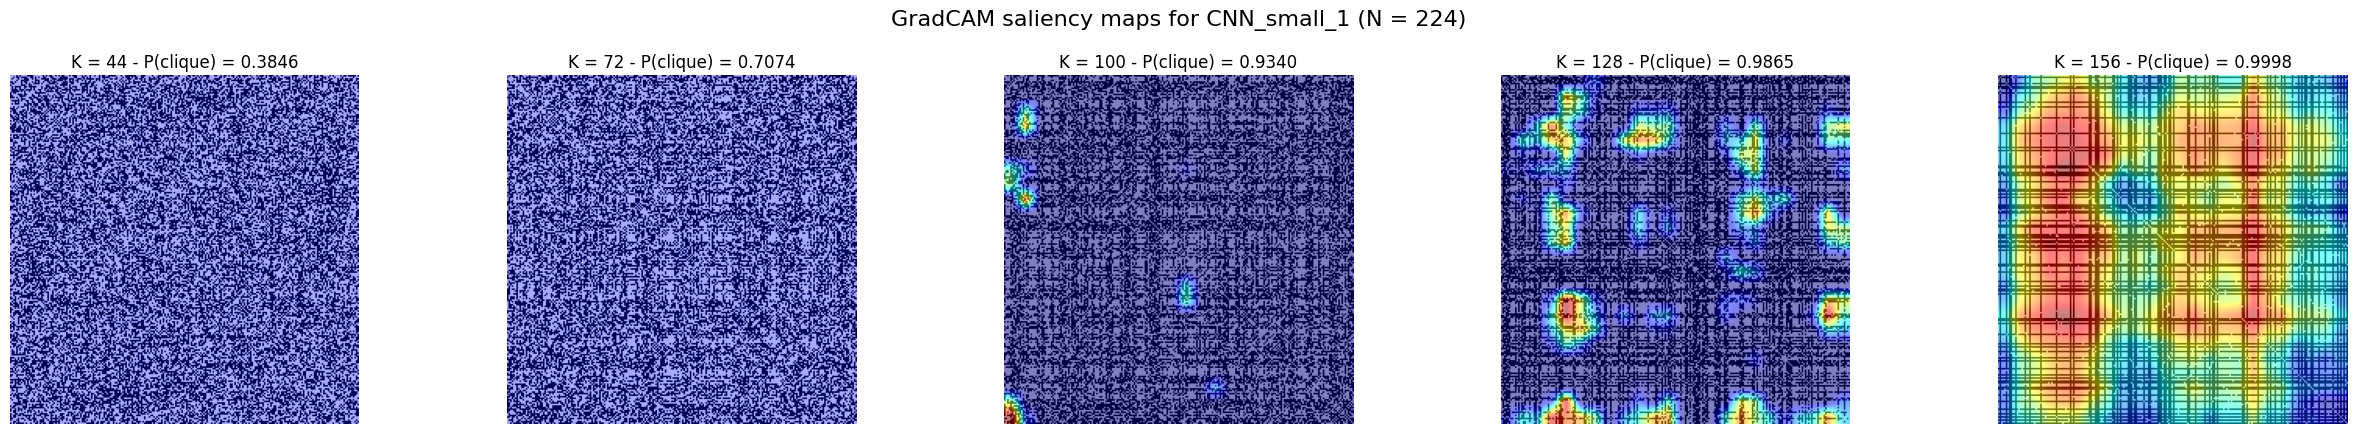

In [133]:
# Testing the function:
# - Define model name:
model_name = "CNN_small_1" # CHANGE THIS TO TEST OTHER MODELS
num_maps = 5    # CHANGE THIS TO TEST MORE OR LESS MAPS
# Call the function:
visualize_gradcam(model_name, num_maps)    